In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools as it
import math as math
from scipy.special import comb

import sys, os, time, numpy as np, matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors,  matplotlib.cm as cm, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
import mpl_toolkits.mplot3d.art3d as art3d

home = os.path.abspath( os.getcwd() + "/.." )
sys.path.append(home)
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import cmath
import math
import pandas as pd

In [2]:
def transfer_matrix_method(a_x, a_y, m, n, t, w, f):
    
  k0 = (2*cmath.pi*f)/343 #wavenumber in air
  
  ds = []
  ls = []
  for i in range(m+n):
    d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
    l = a_y-2*t-d
    ls.append(l)
    ds.append(d)

  d_in = ds[0]
  l_in = ls[0]
  d_out = ds[-1]
  
  Ms = []

  it = 100

  for ii in range(len(ds)-1):
    summation = 0
    for i in range(it): #should be infinity

      k_yn_dash = (i*cmath.pi)/(ls[ii]+ds[ii]+(2*t))
      k_xn_dash = (k0**2 - k_yn_dash**2)**(1/2)

      if i==0:
        psi_n_dash_dash = 1

      else:
        psi_n_dash_dash = ((2**(1/2))/(ds[ii]*k_yn_dash))*((cmath.sin(k_yn_dash*(t+ls[ii]+ds[ii])))-(cmath.sin(k_yn_dash*(t+ls[ii]))))
      summation += ((ds[ii]*k0)*(psi_n_dash_dash**2))/(a_y*k_xn_dash)

    delta1 = 1 + summation
    delta2 = 1 - summation

    alpha = 0
    beta = 0

    for i in range(it): #should be infinity
      k_yn = (i * cmath.pi)/(ls[ii]+ds[ii])
      k_xn = (k0**2 - k_yn**2)**(1/2)

      if i==0:
        phi_n1 = 1
        phi_n2 = 1

      else:
        phi_n1 = ((2)**(1/2)/ds[ii])*(cmath.sin(k_yn*ds[ii])/k_yn)
        phi_n2 = ((2)**(1/2)/(ds[ii]*k_yn))*((cmath.sin(k_yn*(ls[ii]+ds[ii])))-cmath.sin(k_yn*ls[ii]))
        
      alpha += ((k0*ds[ii])*(1+cmath.exp(2j*k_xn*ds[ii]))*phi_n1**2)/(k_xn*(ls[ii]+ds[ii])*(1-cmath.exp(2j*k_xn*ds[ii])))
      beta += (k0*ds[ii]*2*cmath.exp(1j*k_xn*ds[ii])*phi_n1*phi_n2)/(k_xn*(ls[ii]+ds[ii])*(1-cmath.exp(2j*k_xn*ds[ii])))

    M1_11 = (((alpha+1)**2-beta**2)*cmath.exp(-1j*k0*w))/(2*beta)
    M1_12 = (1-alpha**2+beta**2)/(2*beta)
    M1_21 = ((alpha**2)-1-(beta**2))/(2*beta)
    M1_22 = (((beta**2)-((alpha-1)**2))*cmath.exp(1j*k0*w))/(2*beta)
    M1 = [[M1_11, M1_12], [M1_21, M1_22]]
    Ms.append(M1)

  summation1 = 0
  for i in range(it):
    k_yn_dash = (i*cmath.pi)/(l_in+d_in+(2*t))
    k_xn_dash = (k0**2 - k_yn_dash**2)**(0.5)

    if i==0:
      psi_n_dash = 1
    else:
      psi_n_dash = ((2)**(1/2)/d_in)*((cmath.sin(k_yn_dash*(t+d_in))/k_yn_dash)-(cmath.sin(k_yn_dash*(t))/k_yn_dash))

    summation1 += (k0*psi_n_dash**2)/(k_xn_dash)

  alpha_dash = (a_y/d_in) - summation1
  beta_dash = (a_y/d_in) + summation1

  M2_11 = (1-(beta_dash/2)) * cmath.exp(-1j*k0*w)
  M2_12 = (beta_dash/2) * cmath.exp(-1j*k0*w)
  M2_21 = 1 + (alpha_dash/2)
  M2_22 = -alpha_dash/2

  M2 = [[M2_11, M2_12], [M2_21, M2_22]]

  N = Ms[-1]
  for i in range(len(Ms)-1):
    N = np.matmul(N, Ms[len(Ms)-1-i])
  
  N = np.matmul(N, M2)

  n11 = N[0][0]
  n12 = N[0][1]
  n21 = N[1][0]
  n22 = N[1][1]

  T = (2*d_out*((n21*n12)-(n11*n22)))/(a_y*((n12*delta1*cmath.exp(-1j*k0*w))+(n22*delta2)))
  R = -((n11*delta1)+(n21*delta2*cmath.exp(1j*k0*w)))/((n12*delta1)+(n22*delta2*cmath.exp(1j*k0*w)))
  
  magnitude = np.abs(T)
  phase = np.angle(T)

  magnitude_reflection = np.abs(R) #10 * math.log10(np.abs(R))
  phase_reflection = np.angle(R)

  return magnitude, phase, magnitude_reflection, phase_reflection

In [6]:
def generate_dataset(t_num, w_num):

    dataset = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    f = 40000
    lam = 8.661 * 10**(-3)
    a_x = lam*1
    a_y = lam*0.7
    l_min = 0.8*10**(-3)
    d_min = 1.316*10**(-3)
    w_min = 0.4*10**(-3)
    ts = [float(i) for i in np.linspace(0.241*10**(-3), (a_y/2)-(0.8*10**(-3)), t_num)]

    Ts11 = []
    ps11 = []
    Ts12 = []
    ps12 = []
    Ts22 = []
    ps22 = []
    Ts23 = []
    ps23 = []
    Ts33 = []
    ps33 = []
    Ts34 = []
    ps34 = []

    Rs11 = []
    prs11 = []
    Rs12 = []
    prs12 = []
    Rs22 = []
    prs22 = []
    Rs23 = []
    prs23 = []
    Rs33 = []
    prs33 = []
    Rs34 = []
    prs34 = []

    ts11 = []
    ws11 = []
    ts12 = []
    ws12 = []
    ts22 = []
    ws22 = []
    ts23 = []
    ws23 = []
    ts33 = []
    ws33 = []
    ts34 = []
    ws34 = []

    m = 1
    n = 1
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T11, p11, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts11.append(T11)
                if p11<0:
                    p11 = ((p11/np.pi)%2)
                    ps11.append(p11)
                else:
                    p11 = p11 /np.pi
                    ps11.append(p11)
                ts11.append(t)
                ws11.append(w)

                Rs11.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs11.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs11.append(p_r)
                dataset = np.vstack((dataset, np.array([T11, round(p11, 2), R, round(p_r, 2), m, n, t, w])))

    m = 1
    n = 2
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T12, p12, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts12.append(T12)
                if p12<0:
                    p12 = ((p12/np.pi)%2)
                    ps12.append(p12)
                else:
                    p12 = p12 /np.pi
                    ps12.append(p12)
                ts12.append(t)
                ws12.append(w)

                Rs12.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs12.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs12.append(p_r)
                dataset = np.vstack((dataset, np.array([T12, round(p12, 2), R, round(p_r, 2), m, n, t, w])))

    m = 2
    n = 2
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T22, p22, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts22.append(T22)
                if p22<0:
                    p22 = ((p22/np.pi)%2)
                    ps22.append(p22)
                else:
                    p22 = p22 /np.pi
                    ps22.append(p22)
                ts22.append(t)
                ws22.append(w)

                Rs22.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs22.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs22.append(p_r)
                dataset = np.vstack((dataset, np.array([T22, round(p22, 2), R, round(p_r, 2), m, n, t, w])))


    m = 2
    n = 3
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T23, p23, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts23.append(T23)
                if p23<0:
                    p23 = ((p23/np.pi)%2)
                    ps23.append(((p23/np.pi)%2))
                else:
                    p23 = p23 /np.pi
                    ps23.append(p23)
                ts23.append(t)
                ws23.append(w)

                Rs23.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs23.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs23.append(p_r)
                dataset = np.vstack((dataset, np.array([T23, round(p23, 2), R, round(p_r, 2), m, n, t, w])))

    m = 3
    n = 3
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T33, p33, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts33.append(T33)
                if p33<0:
                    p33 = ((p33/np.pi)%2)
                    ps33.append(p33)
                else:
                    p33 = p33 /np.pi
                    ps33.append(p33)
                ts33.append(t)
                ws33.append(w)

                Rs33.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs33.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs33.append(p_r)
                dataset = np.vstack((dataset, np.array([T33, round(p33, 2), R, round(p_r, 2), m, n, t, w])))

    m = 3
    n = 4
    ws = [float(i) for i in np.linspace(w_min, (a_x-((m+n-1)*d_min))/(m+n), w_num)]
    for w in ws:
        #w = round(w, 4)
        for t in ts:
            #t = round(t, 4)
            d = (a_x/(m+n-1)) - ((m+n)/(m+n-1))*w
            l = a_y-2*t-d
            if d>d_min and l>l_min:
                T34, p34, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
                Ts34.append(T34)
                if p34<0:
                    p34 = ((p34/np.pi)%2)
                    ps34.append(p34)
                else:
                    p34 = p34 /np.pi
                    ps34.append(p34)
                ts34.append(t)
                ws34.append(w)

                Rs34.append(R)
                if p_r<0:
                    p_r = ((p_r/np.pi)%2)
                    prs34.append(p_r)
                else:
                    p_r = p_r /np.pi
                    prs34.append(p_r)
                dataset = np.vstack((dataset, np.array([T34, round(p34, 2), R, round(p_r, 2), m, n, t, w])))


    plt.scatter(ps11, Ts11, s = 10)
    plt.scatter(ps12, Ts12, s = 10)
    plt.scatter(ps22, Ts22, s = 10)
    plt.scatter(ps23, Ts23, s = 10)
    plt.scatter(ps33, Ts33, s = 10)
    plt.scatter(ps34, Ts34, s = 10)
    plt.xlabel("Transmission phase/π", size=12)
    plt.ylabel("Transmission amplitude", size = 12)
    plt.legend(["1 coil", "2 coils", '3 coils', '4 coils', '5 coils', '6 coils'], loc ="upper right")
    plt.show()

    dataset = dataset[1:]
    print('The dataset size is:', dataset.shape)

    return dataset

In [7]:
def find_maximum_transmission_amplitude_for_each_phase(dataset, save_data):

    #phase is discritized in 2 dp, find max amplitude at each phase
    amplitudes_maxima = []
    phases_maxima = []
    amplitudes_reflection_maxima = []
    phases_reflection_maxima = []
    m_maxima = []
    n_maxima = []
    t_maxima = []
    w_maxima = []

    df = pd.DataFrame(dataset)

    count = 0

    for i in range(20):
        df1 = df[df[1]==count]
        if np.array(df1).shape[0] != 0: #if there is such a geometry corresponding to that phase
            id = df1[0].argmax()
            aa = df1.iat[id, 0]
            a_ref = df1.iat[id, 2]
            p_ref = df1.iat[id, 3]
            m = df1.iat[id, 4]
            n = df1.iat[id, 5]
            t = df1.iat[id, 6]
            w = df1.iat[id, 7]
            amplitudes_maxima.append(aa)
            phases_maxima.append(count)
            amplitudes_reflection_maxima.append(a_ref)
            phases_reflection_maxima.append(p_ref)
            m_maxima.append(m)
            n_maxima.append(n)
            t_maxima.append(t)
            w_maxima.append(w)
        count += 0.1
        count = round(count, 1)

    plt.scatter(phases_maxima, amplitudes_maxima, s=10)
    plt.xlabel("Transmission phase/π", size=12)
    plt.ylabel("Maximum transmission amplitude", size=12)
    plt.ylim(0, 1)

    if save_data == True:
        dataa = {'Amplitude of transmission coef':amplitudes_maxima, 'Phase of transmission coef':phases_maxima, 
        'Amplitude of reflection coef': amplitudes_reflection_maxima, 'Phase of reflection coef':phases_reflection_maxima, 
        'm':m_maxima, 'n':n_maxima, 't':t_maxima, 'w':w_maxima}
        df = pd.DataFrame(dataa)
        df.to_csv('dataset20.csv')

    return phases_maxima, amplitudes_maxima, phases_reflection_maxima, amplitudes_reflection_maxima, m_maxima, n_maxima, t_maxima, w_maxima

Generate dataset, saved in a csv file

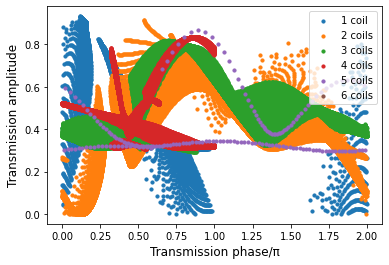

The dataset size is: (94482, 8)


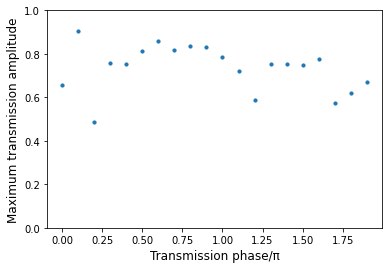

In [10]:
t_num = 200 #number of steps for parameter t
w_num = 200 #number of steps for parameter w
dataset = generate_dataset(t_num, w_num)
#Isolate geometries with maximum amplitude at each phase
save_data = True
phases_maxima, amplitudes_maxima, phases_reflection_maxima, amplitudes_reflection_maxima, m_maxima, n_maxima, t_maxima, w_maxima = find_maximum_transmission_amplitude_for_each_phase(dataset, save_data)

Example of a prediction in the frequency domain

The transmission coefficient's amplitude and phase for an open labyrinthine unit with  bars


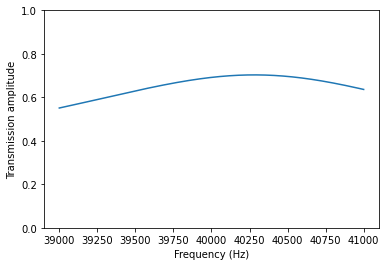

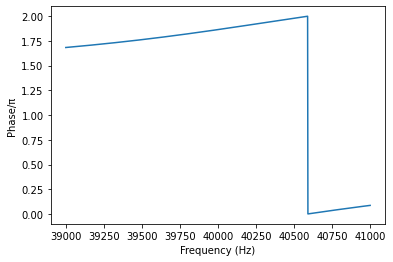

In [9]:
#A prediction in the frequency domain for validation using COMSOL
wavelength_value = 8.661*10**(-3)
a_x = wavelength_value #m
a_y = wavelength_value*0.7 #m
t = 0.0017112585427135679
m = 3 #number of bars
n = 4 #number of bars
w = 0.0003094256999282125

fs = [int(i) for i in np.linspace(39000, 41000, 1000)]
Ts = []
ps = []
Rs = []
p_rs = []

for i in range(len(fs)):
  f = fs[i]
  #print(f)
  T, p, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
  Ts.append(T)
  #ps.append(p/np.pi)
  if p<0:
    ps.append(((p/np.pi)%2))
  else:
    ps.append(p /np.pi)
  Rs.append(R)
  p_rs.append(p_r/np.pi) 

print("The transmission coefficient's amplitude and phase for an open labyrinthine unit with  bars")

plt.plot(fs, Ts)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission amplitude")
plt.ylim(0, 1)
plt.show()

plt.plot(fs, ps)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase/π")
#plt.ylim(0, 2)
plt.show()

In [ ]:
#A prediction in the frequency domain for validation using COMSOL
wavelength_value = 8.661*10**(-3)
a_x = wavelength_value #m
a_y = wavelength_value*0.7 #m
t = 0.0007810949748743718
m = 1 #number of bars
n = 2 #number of bars
w = 0.0008529715242881072

fs = [int(i) for i in np.linspace(39000, 41000, 1000)]
Ts = []
ps = []
Rs = []
p_rs = []

for i in range(len(fs)):
  f = fs[i]
  #print(f)
  T, p, R, p_r = transfer_matrix_method(a_x, a_y, m, n, t, w, f)
  Ts.append(T)
  #ps.append(p/np.pi)
  if p<0:
    ps.append(((p/np.pi)%2))
  else:
    ps.append(p /np.pi)
  Rs.append(R)
  p_rs.append(p_r/np.pi) 

print("The transmission coefficient's amplitude and phase for an open labyrinthine unit with  bars")

plt.plot(fs, Ts)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission amplitude")
plt.ylim(0, 1)
plt.show()

plt.plot(fs, ps)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase/π")
#plt.ylim(0, 2)
plt.show()